# __NLP | Nagative Emotions Detection | Sentiment Analysis__

In [1]:
# Install necessary libraries
!pip install tensorflow transformers

import re
import string
import nltk
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
import re
import string

from transformers import MobileBertTokenizer, TFAutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter
from tqdm.auto import tqdm
from wordcloud import WordCloud


nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
warnings.filterwarnings("ignore", category=FutureWarning)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [2]:
# Functions
stop_words = stopwords.words('english')

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'\w*\d\w*', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def remove_stopwords(text):
    return ' '.join(word for word in text.split() if word not in stop_words)

# lemmatization is more accurate in understanding context and
# meaning of words than stemming
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    # Tokenize and lemmatize each word
    text = ' '.join(lemmatizer.lemmatize(word) for word in text.split())
    return text

def preprocess_data(text):

    # Clean punctuation, URLs, and more
    text = clean_text(text)

    # Remove stopwords
    text = remove_stopwords(text)

    # Apply lemmatization (replacing stemming)
    text = lemmatize_text(text)

    return text

def get_top_words_by_label(df, text_column, label_column, top_n=50):
    label_word_counts = {}

    for label in df[label_column].unique():
        # Filter rows for the specific label
        label_data = df[df[label_column] == label]

        # Combine all cleaned statements into one large string
        all_text = " ".join(label_data[text_column].tolist())

        # Tokenize into words
        words = all_text.split()

        # Count word frequencies
        word_counts = Counter(words)

        # Get the top N words
        label_word_counts[label] = word_counts.most_common(top_n)

    return label_word_counts

## Load Dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
file_path = '/content/drive/MyDrive/colab_NLP/dataset/mentalhealth.csv'
df = pd.read_csv(file_path, dtype={1: str, 2:str})

In [5]:
df.head()

,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety


In [6]:
df.isna().sum()

,0
Unnamed: 0,0
statement,362
status,0


In [7]:
df.dropna(inplace=True)

In [8]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52681 entries, 0 to 53042
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   statement  52681 non-null  object
 1   status     52681 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


In [10]:
df.describe()

,statement,status
count,52681,52681
unique,51073,7
top,what do you mean?,Normal
freq,22,16343


## Pre-processing

In [11]:
df_clean = df.copy()
df_clean['statement'] = df['statement'].apply(preprocess_data)
df_clean.head()

,statement,status
0,oh gosh,Anxiety
1,trouble sleeping confused mind restless heart ...,Anxiety
2,wrong back dear forward doubt stay restless re...,Anxiety
3,ive shifted focus something else im still worried,Anxiety
4,im restless restless month boy mean,Anxiety


In [12]:
# Remove outliers: Remove the 19 longest sentences
# Ensure all remaining sentences in the statement column of df_clean are within 10k characters
df_clean['length'] = df_clean['statement'].apply(len)
df_clean = df_clean.sort_values(by='length', ascending=False).iloc[19:]
df_clean = df_clean[df_clean['length'] <= 10000]
df_clean = df_clean.drop(columns=['length'])
df_clean = df_clean.reset_index(drop=True)

print(df_clean.shape)

(52662, 2)


In [13]:
# Encode labels into integers
label_encoded = {label: i for i, label in enumerate(df_clean['status'].unique())}

# Print the mapping of labels
print("Label Mapping:")
for key, value in label_encoded.items():
    print(f"{value}: {key}")

# Map the 'status' column to the encoded integers
df_clean['status'] = df_clean['status'].map(label_encoded)

df_clean.head()

Label Mapping:
0: Depression
1: Suicidal
2: Bipolar
3: Stress
4: Anxiety
5: Personality disorder
6: Normal


,statement,status
0,hello everyonei rarely post reddit buti nowher...,0
1,introduction guess name michael yo live slovak...,0
2,someone living turkey age probably lower posti...,1
3,year old grown deeper depression since going g...,0
4,happened little ago still bother person suppos...,0


## EDA to find Cue Words

### Most Frequently Occurring Words
Top 50 most frequently occurring words for each label

In [14]:
# Get top words for each label
top_words_by_label = get_top_words_by_label(df_clean, 'statement', 'status')

In [15]:
# Print results
for label, words in top_words_by_label.items():
    print(f"Label: {label}")
    for word, count in words:
        print(f"  {word}: {count}")
    print("---")

Label: 0
  like: 18225
  feel: 18139
  want: 12608
  life: 11401
  know: 11027
  get: 10501
  time: 9429
  even: 9056
  people: 7851
  thing: 7716
  year: 7431
  day: 7408
  would: 7304
  really: 7111
  cannot: 6886
  friend: 6796
  one: 6645
  depression: 6347
  going: 5894
  make: 5883
  think: 5761
  go: 5741
  never: 5380
  much: 5187
  help: 5052
  feeling: 4716
  anything: 4426
  work: 4264
  could: 4252
  thought: 4125
  back: 4030
  always: 4017
  everything: 3880
  way: 3874
  still: 3834
  better: 3800
  anymore: 3759
  good: 3747
  something: 3694
  got: 3598
  nothing: 3595
  hate: 3593
  need: 3543
  every: 3533
  wa: 3508
  see: 3394
  someone: 3359
  job: 3338
  anyone: 3303
  family: 3281
---
Label: 1
  want: 11082
  like: 9116
  feel: 8512
  life: 7963
  know: 6799
  cannot: 6577
  get: 5663
  would: 5657
  even: 5131
  time: 4948
  people: 4767
  one: 4405
  going: 4245
  year: 4220
  think: 4072
  thing: 4049
  friend: 3839
  really: 3816
  day: 3686
  never: 3670
  

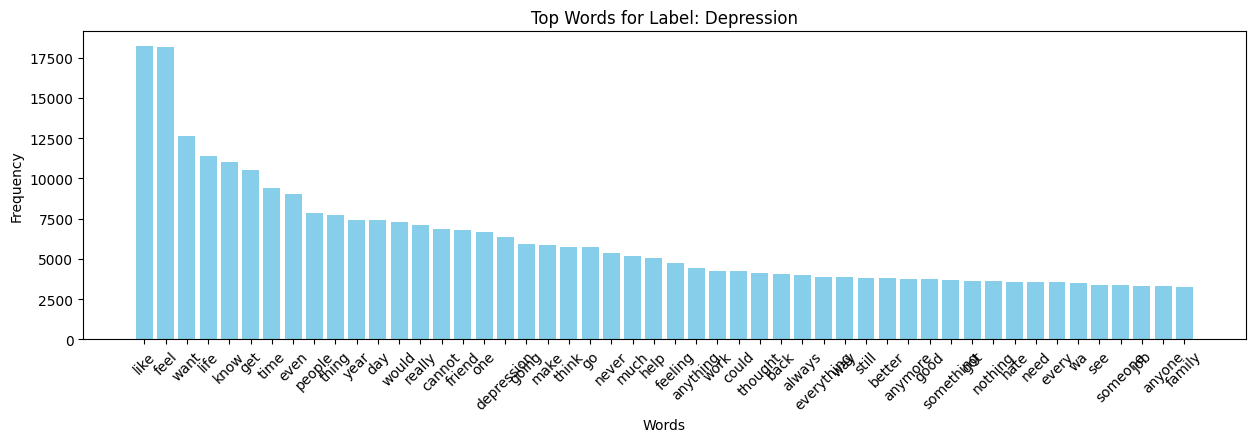

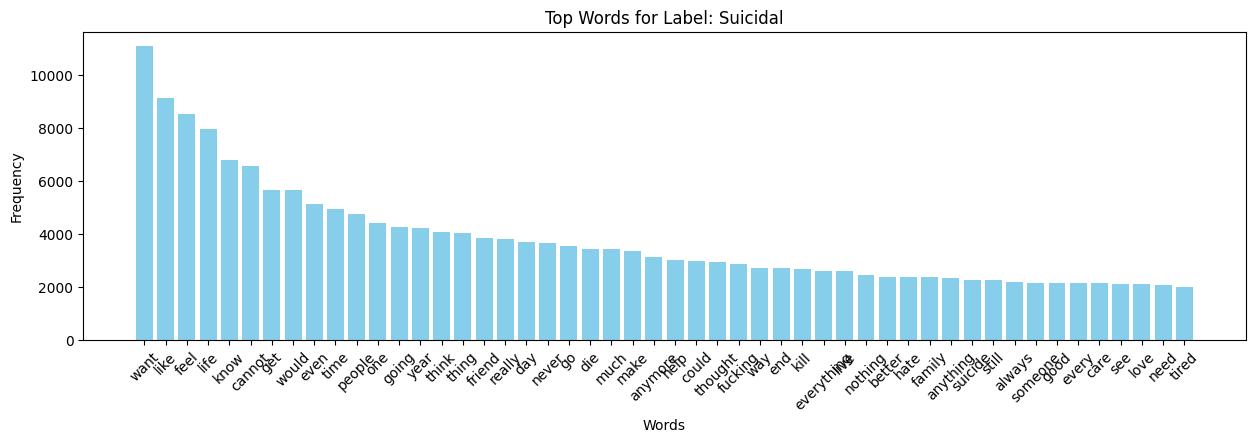

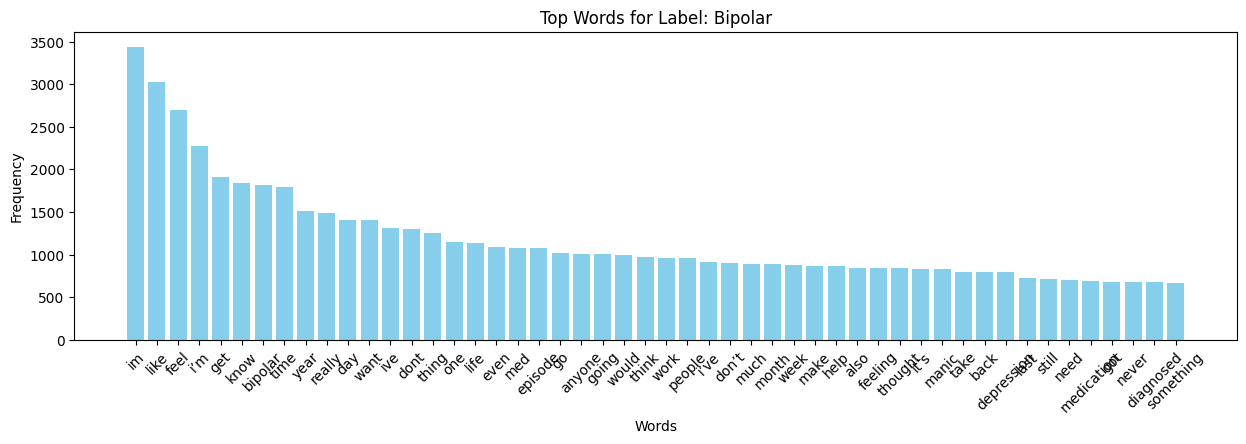

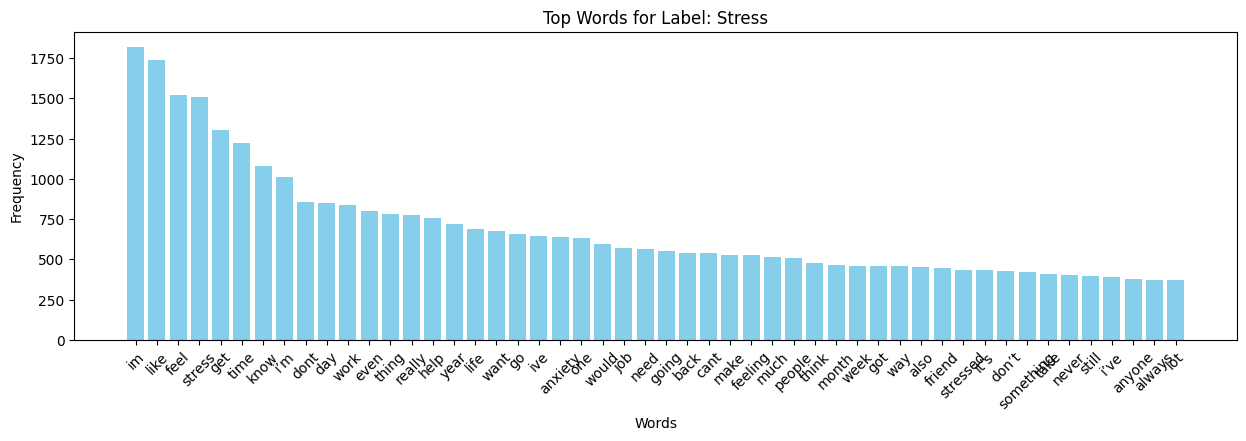

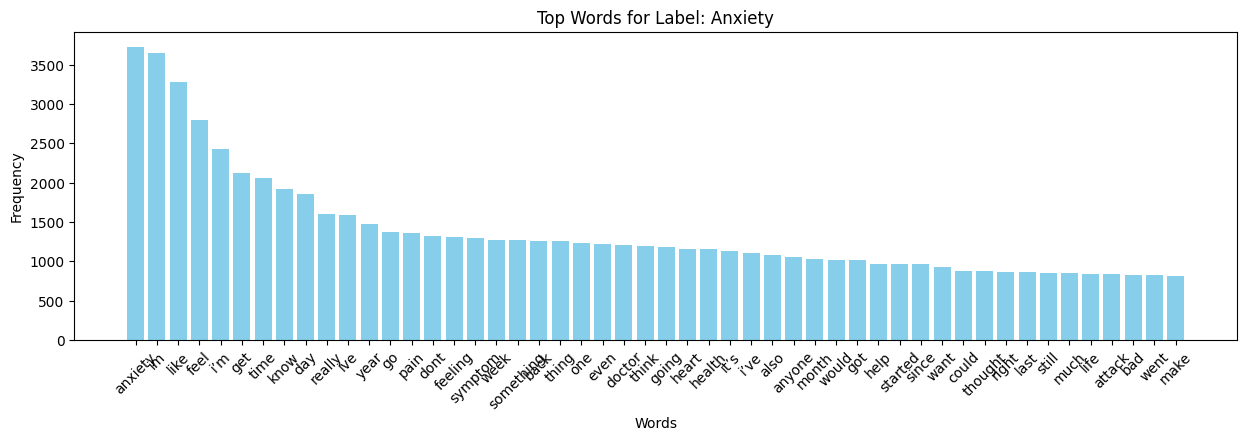

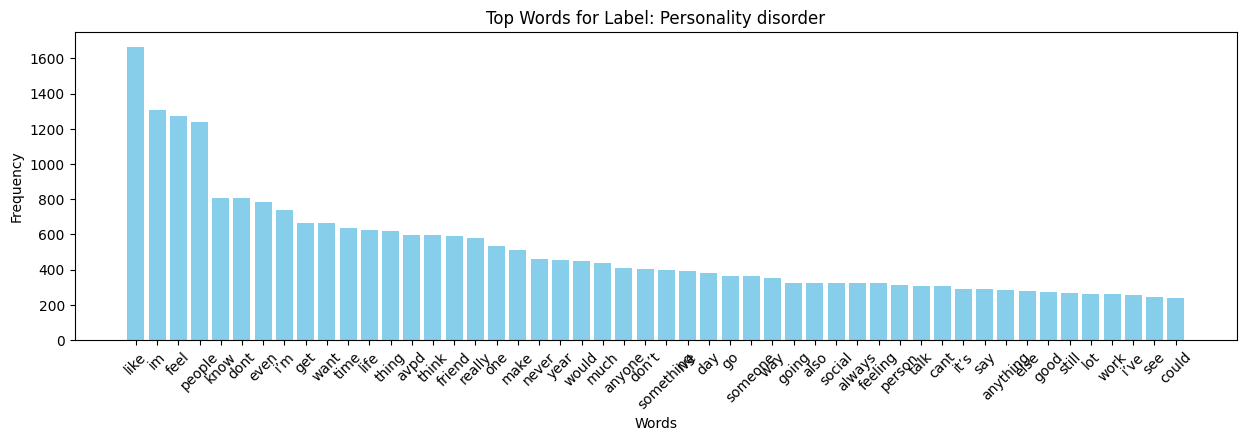

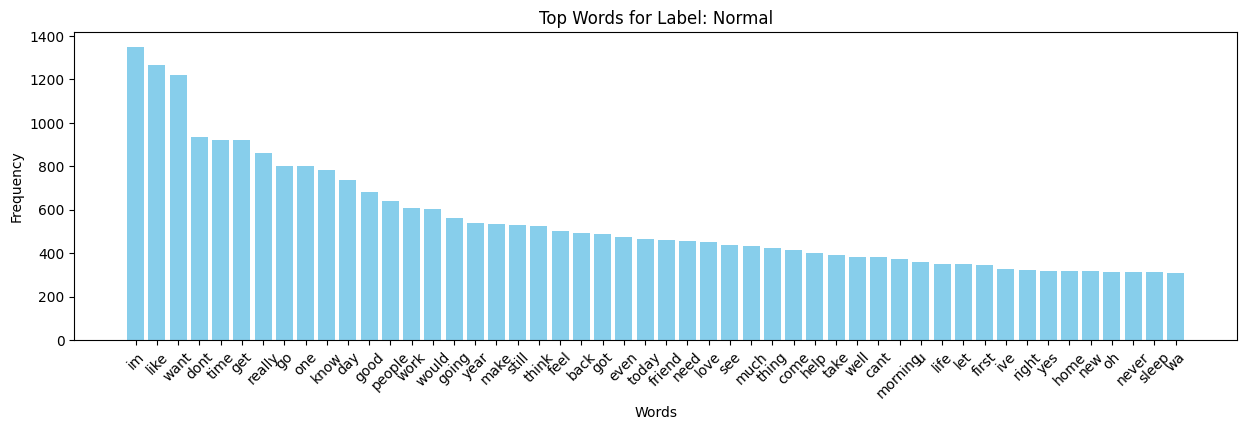

In [16]:
# Visualize the results
def plot_top_words(top_words_by_label, class_labels):
    for label, words in top_words_by_label.items():
        words, counts = zip(*words)
        plt.figure(figsize=(15, 4))
        plt.bar(words, counts, color='skyblue')
        plt.title(f"Top Words for Label: {class_labels[label]}")
        plt.xlabel("Words")
        plt.ylabel("Frequency")
        plt.xticks(rotation=45)
        plt.show()

class_labels = {0: 'Depression', 1: 'Suicidal', 2: 'Bipolar', 3: 'Stress',
                4: 'Anxiety', 5: 'Personality disorder', 6: 'Normal'}

plot_top_words(top_words_by_label, class_labels)

### WordCloud

In [17]:
class_labels = {0: 'Depression', 1: 'Suicidal', 2: 'Bipolar', 3: 'Stress',
                4: 'Anxiety', 5: 'Personality disorder', 6: 'Normal'}

# Loop through each category to generate word clouds
for cat in class_labels:
    # Combine all statements for the current category
    statements = " ".join(df_clean[df_clean['status'] == cat]['statement'])

    # Generate a word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(statements)

    # Plot the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Word Cloud for {class_labels[cat]}", fontsize=16)
    plt.axis('off')  # Hide axes
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

## Load Tokenization and Model

In [18]:
X = df_clean['statement']
y = df_clean['status']

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print(len(X_train), len(y_train))
print(len(X_test), len(y_test))

42129 42129
10533 10533


In [19]:
print((X_train.shape), (y_train.shape))

(42129,) (42129,)


In [20]:
# Convert train_labels and val_labels to lists
y_train = y_train.tolist()
y_test = y_test.tolist()
print(len(X_train), len(y_train))
print(len(X_test), len(y_test))

42129 42129
10533 10533


In [21]:
model_name = "google/mobilebert-uncased"
tokenizer = MobileBertTokenizer.from_pretrained(model_name)
num_labels = 7
model = TFAutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/847 [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/164M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFMobileBertForSequenceClassification.

Some layers of TFMobileBertForSequenceClassification were not initialized from the model checkpoint at google/mobilebert-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
# Save tokenizer's vocab.txt and other configuration files
tokenizer.save_pretrained("/content/drive/MyDrive/colab_NLP/model")

('/content/drive/MyDrive/colab_NLP/model/tokenizer_config.json',
 '/content/drive/MyDrive/colab_NLP/model/special_tokens_map.json',
 '/content/drive/MyDrive/colab_NLP/model/vocab.txt',
 '/content/drive/MyDrive/colab_NLP/model/added_tokens.json')

In [23]:
# Tokenize Text
train_encodings = tokenizer(list(X_train), truncation=True, padding="max_length", max_length=256)
test_encodings = tokenizer(list(X_test), truncation=True, padding="max_length", max_length=256)

In [24]:
# Prepare TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), y_train)).shuffle(100).batch(16)
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), y_test)).batch(16)

In [25]:
# Freeze all layers
for layer in model.layers:
    layer.trainable = False

# Unfreeze only the last few layers
for layer in model.layers[-3:]:
    layer.trainable = True

In [26]:
# Compute Class Weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

## Model Training

In [27]:
# Model Training
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [28]:
# Train the model and log epoch results
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

epochs = 10
for epoch in range(epochs):
    # Train
    history = model.fit(train_dataset, validation_data=test_dataset, epochs=1)

    train_loss = history.history['loss'][-1]
    train_accuracy = history.history['sparse_categorical_accuracy'][-1]
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    test_loss = history.history['val_loss'][-1]
    test_accuracy = history.history['val_sparse_categorical_accuracy'][-1]
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    # Print results
    print(f'Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')
    print(f'Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}')

    # Early Stopping
    if epoch > 0 and test_accuracy < test_accuracies[-2]:  # Compare with the accuracy from two epochs ago
      print(f"Early stopping triggered at epoch {epoch + 1}. Best test accuracy so far: {test_accuracies[-1]:.4f}")
      break


2634/2634 [==============================] - 1454s 469ms/step - loss: 59276.4375 - sparse_categorical_accuracy: 0.2320 - val_loss: 2.3514 - val_sparse_categorical_accuracy: 0.3516
Epoch 1, Train Loss: 59276.4375, Test Loss: 2.3514
Train Accuracy: 0.2320, Test Accuracy: 0.3516
2634/2634 [==============================] - 1260s 479ms/step - loss: 3.5490 - sparse_categorical_accuracy: 0.4378 - val_loss: 1.6079 - val_sparse_categorical_accuracy: 0.4894
Epoch 2, Train Loss: 3.5490, Test Loss: 1.6079
Train Accuracy: 0.4378, Test Accuracy: 0.4894
2634/2634 [==============================] - 1198s 455ms/step - loss: 17.5977 - sparse_categorical_accuracy: 0.4961 - val_loss: 1.2734 - val_sparse_categorical_accuracy: 0.5206
Epoch 3, Train Loss: 17.5977, Test Loss: 1.2734
Train Accuracy: 0.4961, Test Accuracy: 0.5206
2634/2634 [==============================] - 1200s 456ms/step - loss: 1.2644 - sparse_categorical_accuracy: 0.5250 - val_loss: 1.1945 - val_sparse_categorical_accuracy: 0.5505
Epoch 4

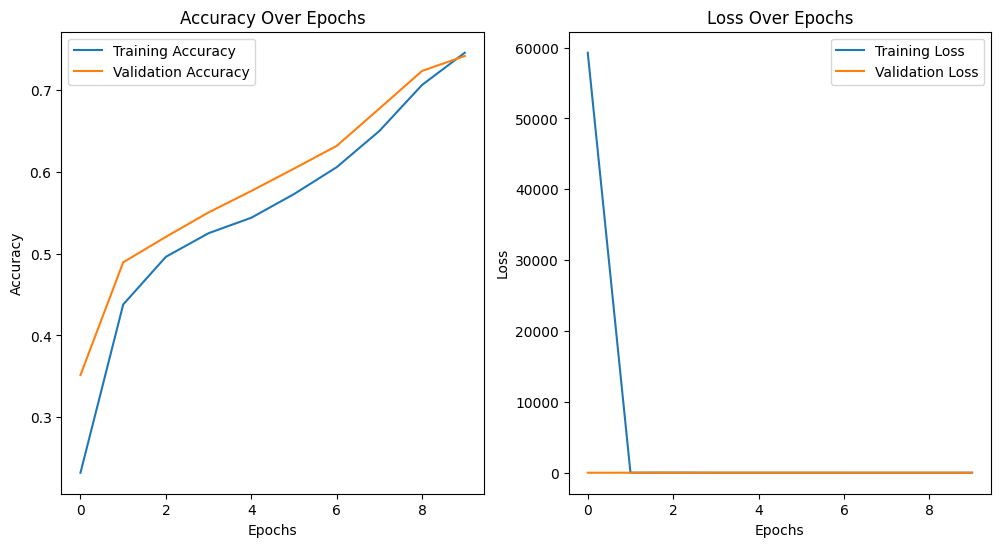

In [29]:
# Plot Training and Validation Metrics
plt.figure(figsize=(12, 6))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(test_accuracies, label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

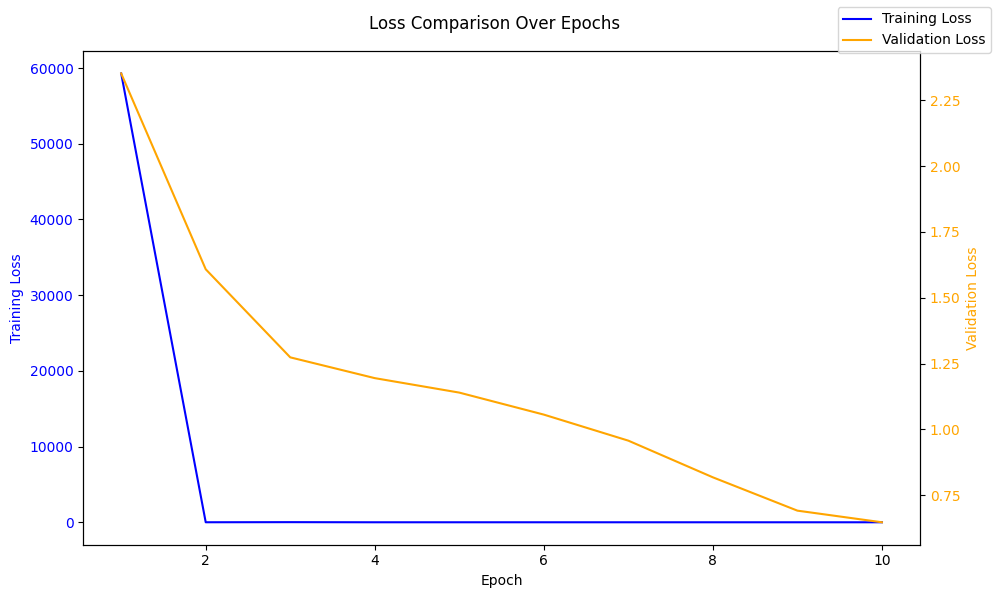

In [30]:
epochs = range(1, len(train_losses) + 1)
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Training Loss on the left y-axis
ax1.plot(epochs, train_losses, label='Training Loss', color='blue')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Training Loss', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Plot Validation Loss on the right y-axis
ax2 = ax1.twinx()
ax2.plot(epochs, test_losses, label='Validation Loss', color='orange')
ax2.set_ylabel('Validation Loss', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Add a single legend for both lines
lines_1, labels_1 = ax1.get_legend_handles_labels()  # Get legend for ax1
lines_2, labels_2 = ax2.get_legend_handles_labels()  # Get legend for ax2
fig.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')

# Add a title and layout
fig.suptitle('Loss Comparison Over Epochs')
fig.tight_layout()
plt.show()

# Download Model


(Applying quantization (converter.optimizations = [tf.lite.Optimize.DEFAULT]) requires additional computations and memory to analyze activations and optimize for smaller size.)

In [32]:
# Convert to TensorFlow Lite
# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# converter.optimizations = [tf.lite.Optimize.DEFAULT]
# tflite_quantized_model = converter.convert()

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]

# Reduce memory consumption during conversion
converter.experimental_new_converter = True  # Use experimental memory-efficient converter
converter.experimental_enable_resource_variables = True  # Avoid resource-heavy operations
tflite_quantized_model = converter.convert()

In [33]:
# Show model size in KBs.
quantized_model_size = len(tflite_quantized_model) / 1024
print('Quantized model size = %dKBs' % quantized_model_size)

Quantized model size = 26629KBs


In [34]:
import datetime

current_timestamp = datetime.datetime.now()
filename = "mobilebert_%s.tflite" % current_timestamp.strftime("%Y%m%d_%H%M%S")

# Save the quantized model to file to the Downloads directory
f = open(filename, "wb")
f.write(tflite_quantized_model)
f.close()

# Download the digit classification model
from google.colab import files
files.download(filename)
print('%s has been downloaded' % filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

mobilebert_20241216_064804.tflite has been downloaded


In [35]:
# https://www.tensorflow.org/tutorials/keras/save_and_load

# Manually Save Weights
# Save the weights
model.save_weights('/content/drive/MyDrive/colab_NLP/saved_newmodel/checkpoints/my_checkpoint')

# Save Entired Model
# Save the entire model as a SavedModel
# Preserves everything, including the model's architecture, weights, and training configuration
model.save('/content/drive/MyDrive/colab_NLP/saved_newmodel/my_model')

# # Save As HDF5 format
# # Save the entire model to a HDF5 file.
# # The '.h5' extension indicates that the model should be saved to HDF5.
# # HDF5 format saves the model's architecture and weights but doesn't include the optimizer's state by default
# model.save('/content/drive/MyDrive/WQF7007_NLP_GroupProject/Task_1/colab/saved_newmodel/my_model.h5')